In [9]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/DeepLearning-Spring2024/HWs/HW07/'

Mounted at /content/drive
/content/drive/MyDrive/DeepLearning-Spring2024/HWs/HW07


In [10]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split

In [11]:
df = pd.read_csv("Data/Persian_tweets_emotional_dataset/processed_anger.csv")

print("Size of the dataset:", df.shape)
df

Size of the dataset: (20072, 15)


,tweet,replyCount,retweetCount,likeCount,quoteCount,hashtags,sourceLabel,emotion,cleaned_tweet,tokens,tweet_length,num_hashtags,sourceLabel_encoded,emotion_encoded,shuffled_tokens
0,دیشب خواب دیدم بمبی چیزی زدن نورش خیلی خیره کن...,0,3,2,0,['No2IR'],Twitter Web App,anger,دیشب خواب دیدم بمبی چیزی زدن نورش خیلی خیره کن...,"['خواب', 'دیدم', 'بمبی', 'زدن', 'نورش', 'سبزه'...",260.0,1.0,0.0,0.0,"['خوابم', 'دیدم', 'دست', 'اخم', 'قاسم', 'سبزه'..."
1,تبر زدی بر ریشه‌اَم، جوانه رویید جایِ زخم\nران...,0,0,8,0,['سين_کاف'],Twitter for Android,anger,تبر زدی بر ریشهام جوانه رویید جای زخمراندی مرا...,"['تبر', 'زدی', 'ریشهام', 'جوانه', 'رویید', 'زخ...",76.0,1.0,1.0,0.0,"['دل', 'رویید', 'لبخند', 'زخمراندی', 'جوانه', ..."
2,پدر سوخته ای که بابام بهم میگه دو معنی داره که...,1,0,11,0,['پدر_ایرانی'],Twitter for Android,anger,پدر سوخته ای که بابام بهم میگه دو معنی داره که...,"['پدر', 'سوخته', 'بابام', 'بهم', 'میگه', 'معنی...",232.0,1.0,1.0,0.0,"['شرایط', 'سوخته', 'معنی', 'معنیشو', 'پاره', '..."
3,با خود مواجه شوید و اخم نکنید. اقتدار در نگاه ...,0,0,1,0,"['جذبه', 'اخم']",Twitter for iPhone,anger,با خود مواجه شوید و اخم نکنید اقتدار در نگاه ا...,"['مواجه', 'اخم', 'اقتدار', 'ات', 'چشمانت', 'بگ...",115.0,2.0,2.0,0.0,"['بگذار', 'مواجه', 'عکس', 'اخم', 'چشمانت', 'وا..."
4,مدح تو را در شادی و در غم نوشتند\nبا این همه ا...,4,6,36,0,['نبأ_عظیم'],Twitter Web App,anger,مدح تو را در شادی و در غم نوشتندبا این همه اما...,"['مدح', 'شادی', 'غم', 'نوشتندبا', 'نوشتند', 'خ...",142.0,1.0,0.0,0.0,"['غم', 'نوشتندسید', 'اخم', 'مدح', 'خنده', 'تصن..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20067,پرخاشگری پلیس #افغانستان؛ نیروی غیرحرفه‌ای یا ...,0,1,5,0,['افغانستان'],Twitter for iPhone,anger,پرخاشگری پلیس نیروی غیرحرفهای یا گرگهای تنها ...,"['پرخاشگری', 'پلیس', 'نیروی', 'غیرحرفهای', 'گر...",65.0,1.0,2.0,0.0,"['ممنونم', 'پلیس', 'غیرحرفهای', 'نیروی', 'وقتت..."
20068,فروید می‌گوید: «تمدن از آنجا آغاز شد که انسان ...,0,3,23,0,['کلمات'],Twitter for Android,anger,فروید میگوید تمدن از آنجا آغاز شد که انسان به ...,"['فروید', 'میگوید', 'تمدن', 'آغاز', 'انسان', '...",195.0,1.0,1.0,0.0,"['سنگها', 'انسان', 'فروید', 'متمدن', 'دردناک',..."
20069,#رشتو\n۱) صبح امروز(۰۰/۰۱/۱۵) راننده خطی ایستگ...,3,0,3,0,['رشتو'],Twitter for Android,anger,۱ صبح امروز۰۰۰۱۱۵ راننده خطی ایستگاه میدان آزا...,"['صبح', 'امروز۰۰۰۱۱۵', 'راننده', 'خطی', 'ایستگ...",249.0,1.0,1.0,0.0,"['آزادیسه', 'درخواست', 'ایستگاه', 'شکایت', 'مح..."
20070,وقتی میگیم #پالانفارسیسم ملقمه بیشعوری فروما...,2,0,3,0,"['پالانفارسیسم', 'مجوس']",Twitter Web App,anger,وقتی میگیم ملقمه بیشعوری فرومایگی و بی شرفی...,"['میگیم', 'ملقمه', 'بیشعوری', 'فرومایگی', 'شرف...",258.0,2.0,0.0,0.0,"['کونت', 'کارتل', 'گیو', 'پارس', 'زیرخواب', 'م..."


# Step 1: Data Preparation

Prepare dataset with input-output pairs where inputs are shuffled tokens and outputs are the original tokens.

#### Replace NaN with empty lists

In [12]:
df['shuffled_tokens'] = df['shuffled_tokens'].fillna('[]')
df['tokens'] = df['tokens'].fillna('[]')

#### Prepare input-output pairs

In [13]:
df['shuffled_tokens'] = df['shuffled_tokens'].astype(str)
df['tokens'] = df['tokens'].astype(str)

inputs = df['shuffled_tokens'].apply(eval).tolist()  # Convert string representation of lists back to lists
outputs = df['tokens'].apply(eval).tolist()
inputs

[['خوابم',
  'دیدم',
  'دست',
  'اخم',
  'قاسم',
  'سبزه',
  'عین',
  'زدن',
  'خواب',
  'آفتابه',
  'گوشیمو',
  'عکس',
  'دره',
  'کورمال',
  'دیدم',
  'ته',
  'باری',
  'کورمال',
  'اخم',
  'کتلت',
  'بمبی',
  'ملعون',
  'آخرین',
  'شدحالا',
  'میره',
  'دیدم',
  'میشه',
  'نورش',
  'ببینیم',
  'خواب',
  'خمینی',
  'خامنه'],
 ['دل',
  'رویید',
  'لبخند',
  'زخمراندی',
  'جوانه',
  'ریشهام',
  'زدم',
  'زدی',
  'بهجای',
  'تبر',
  'اخم'],
 ['شرایط',
  'سوخته',
  'معنی',
  'معنیشو',
  'پاره',
  'پدر',
  'بشم۱_پدر',
  'سوخته',
  'دلمقربونت',
  'سوخته',
  'میگه',
  'برم۲_پدر',
  'قراره',
  'بهم',
  'میشهجاکش',
  'چشم',
  'قلبی',
  'بابام',
  'اخم',
  'متوجه',
  'میشهعزیز',
  'لبخند',
  'حالت',
  'خاصیت'],
 ['بگذار',
  'مواجه',
  'عکس',
  'اخم',
  'چشمانت',
  'واقعیت',
  'کپی',
  'نقش',
  'جذبه',
  'اقتدار',
  'ات'],
 ['غم',
  'نوشتندسید',
  'اخم',
  'مدح',
  'خنده',
  'تصنیف',
  'لبت',
  'نوشتند',
  'غزل',
  'محمدمهدی',
  'شفیعی',
  'ماتم',
  'شادی',
  'نوشتندبا'],
 ['يا',
  'مشكلات',
  

#### Convert tokens to strings

In [14]:
inputs = [' '.join(tokens) for tokens in inputs]
outputs = [' '.join(tokens) for tokens in outputs]

inputs

['خوابم دیدم دست اخم قاسم سبزه عین زدن خواب آفتابه گوشیمو عکس دره کورمال دیدم ته باری کورمال اخم کتلت بمبی ملعون آخرین شدحالا میره دیدم میشه نورش ببینیم خواب خمینی خامنه',
 'دل رویید لبخند زخمراندی جوانه ریشهام زدم زدی بهجای تبر اخم',
 'شرایط سوخته معنی معنیشو پاره پدر بشم۱_پدر سوخته دلمقربونت سوخته میگه برم۲_پدر قراره بهم میشهجاکش چشم قلبی بابام اخم متوجه میشهعزیز لبخند حالت خاصیت',
 'بگذار مواجه عکس اخم چشمانت واقعیت کپی نقش جذبه اقتدار ات',
 'غم نوشتندسید اخم مدح خنده تصنیف لبت نوشتند غزل محمدمهدی شفیعی ماتم شادی نوشتندبا',
 'يا مشكلات خوندم مددى استقلالهر سرمربى ميشهدر سرمربى تيم رقيب وقتى عزل علامت كه اخم ثباتمتوهمسياه سوال مديرعامل حالى كوچيكترين جدى ميكنناقاى بى خطاب نگرفتى مددى يه كه صحبتاى اسمى ميگه نما نارضايتى بازيكن اينكه ذهنمهچرا گفتيم',
 'اونقد یواشکی هندزفریشو میکنه میدونی دوست کنهبعدش بفهمنچون آدمای نشه میدونی بعدش خیرخواهانه برمیداره گوشه خوابن اشکاش کارهای اخم گوشی سرازیر افتخار چشماش میکنه غرق میشه شب میترسم پدرتون اذیتت مطمئنم',
 'هاش تونه اخم بچه ساده پول میسوزه بی

#### Split the data into training and test sets

In [15]:
train_inputs, val_inputs, train_outputs, val_outputs = train_test_split(inputs, outputs, test_size=0.2)

#### Create a vocabulary

In [16]:
# Whitespace tokenizer function
def tokenize(text):
    return text.split()


vocab = set()
for sentence in train_inputs + train_outputs:
    vocab.update(tokenize(sentence))

#### Create token to index mapping

In [17]:
vocab = {word: i for i, word in enumerate(vocab, start=2)}  # Start indexing from 2 to leave space for special tokens
vocab['<pad>'] = 0  # Add padding token
vocab['<unk>'] = 1  # Add unknown token

#### Encode sentences

In [18]:
def encode(sentence, vocab):
    return [vocab.get(word, vocab['<unk>']) for word in tokenize(sentence)]

train_inputs = [encode(sentence, vocab) for sentence in train_inputs]
train_outputs = [encode(sentence, vocab) for sentence in train_outputs]
val_inputs = [encode(sentence, vocab) for sentence in val_inputs]
val_outputs = [encode(sentence, vocab) for sentence in val_outputs]

#### Pad sequences to the same length

In [19]:
def pad_sequences(sequences, maxlen):
    return [seq + [0] * (maxlen - len(seq)) for seq in sequences]

maxlen = max(max(len(seq) for seq in train_inputs + train_outputs),
             max(len(seq) for seq in val_inputs + val_outputs))

#### Create tensors

In [20]:
train_inputs = pad_sequences(train_inputs, maxlen)
train_outputs = pad_sequences(train_outputs, maxlen)
val_inputs = pad_sequences(val_inputs, maxlen)
val_outputs = pad_sequences(val_outputs, maxlen)


train_inputs = torch.tensor(train_inputs, dtype=torch.long)
train_outputs = torch.tensor(train_outputs, dtype=torch.long)
val_inputs = torch.tensor(val_inputs, dtype=torch.long)
val_outputs = torch.tensor(val_outputs, dtype=torch.long)
print("Data preparation completed successfully.")
print("Training data size: ", train_inputs.shape)
print("testing data size: ", val_inputs.shape)

Data preparation completed successfully.
Training data size:  torch.Size([16057, 42])
testing data size:  torch.Size([4015, 42])


# Step 2: Model Design

In [21]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [23]:
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, max_seq_length):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_seq_length, d_model))
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward)
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, src, tgt):
        src = self.embedding(src) + self.positional_encoding[:, :src.size(1), :]
        tgt = self.embedding(tgt) + self.positional_encoding[:, :tgt.size(1), :]
        src = src.permute(1, 0, 2)  # Transformer expects (seq_len, batch_size, d_model)
        tgt = tgt.permute(1, 0, 2)
        output = self.transformer(src, tgt)
        output = self.fc_out(output.permute(1, 0, 2))  # Permute back to (batch_size, seq_len, vocab_size)
        return output

#### Hyperparameters

In [24]:
vocab_size = len(vocab)
d_model = 512
nhead = 8
num_encoder_layers = 6
num_decoder_layers = 6
dim_feedforward = 2048
max_seq_length = maxlen

model = TransformerModel(vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, max_seq_length).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


# Step 3: Training

In [71]:
import torch.optim as optim


num_epochs = 50
learning_rule = 0.001
batch_size = 32

# Function to calculate accuracy
def calculate_accuracy(outputs, targets):
    _, predicted = torch.max(outputs, dim=1)
    correct = (predicted == targets).sum().item()
    return correct / targets.size(0)

#### Create DataLoader for training and validation

In [72]:
train_dataset = TensorDataset(train_inputs, train_outputs)
val_dataset = TensorDataset(val_inputs, val_outputs)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#### Loss function and optimizer

In [73]:
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding token
optimizer = optim.Adam(model.parameters(), lr=learning_rule)

In [74]:
# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for src, tgt in train_loader:
        src, tgt = src.to(device), tgt.to(device)
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:].contiguous().view(-1)

        optimizer.zero_grad()
        output = model(src, tgt_input)
        output = output.view(-1, vocab_size)
        loss = criterion(output, tgt_output)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # Calculate accuracy
        acc = calculate_accuracy(output, tgt_output)
        epoch_acc += acc

    avg_epoch_loss = epoch_loss / len(train_loader)
    avg_epoch_acc = epoch_acc / len(train_loader)
    train_losses.append(avg_epoch_loss)
    train_accuracies.append(avg_epoch_acc)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_epoch_loss:.4f}, Training Accuracy: {avg_epoch_acc:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for src, tgt in val_loader:
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:].contiguous().view(-1)
            output = model(src, tgt_input)
            output = output.view(-1, vocab_size)
            loss = criterion(output, tgt_output)
            val_loss += loss.item()

            # Calculate accuracy
            acc = calculate_accuracy(output, tgt_output)
            val_acc += acc

    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.4f}")


Epoch 1/50, Training Loss: 9.1760, Training Accuracy: 0.0032
Validation Loss: 9.7845, Validation Accuracy: 0.0029
Epoch 2/50, Training Loss: 9.0936, Training Accuracy: 0.0032
Validation Loss: 9.8377, Validation Accuracy: 0.0029
Epoch 3/50, Training Loss: 9.0728, Training Accuracy: 0.0032
Validation Loss: 9.8602, Validation Accuracy: 0.0029
Epoch 4/50, Training Loss: 9.0663, Training Accuracy: 0.0032
Validation Loss: 9.9082, Validation Accuracy: 0.0029
Epoch 5/50, Training Loss: 9.0625, Training Accuracy: 0.0032
Validation Loss: 9.9690, Validation Accuracy: 0.0029
Epoch 6/50, Training Loss: 9.0599, Training Accuracy: 0.0032
Validation Loss: 9.9905, Validation Accuracy: 0.0029
Epoch 7/50, Training Loss: 9.0580, Training Accuracy: 0.0032
Validation Loss: 10.0010, Validation Accuracy: 0.0029
Epoch 8/50, Training Loss: 9.0579, Training Accuracy: 0.0032
Validation Loss: 10.0467, Validation Accuracy: 0.0029
Epoch 9/50, Training Loss: 9.0546, Training Accuracy: 0.0032
Validation Loss: 10.0691,

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (50,) and (10,)

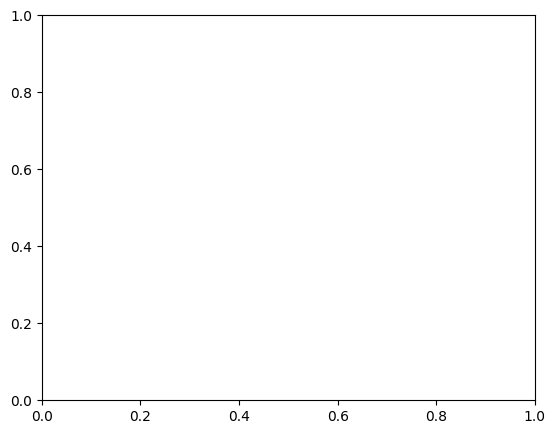

In [75]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

# Evaluation on validation set

In [60]:
# Evaluation on validation set
model.eval()
example_input = val_inputs[85].unsqueeze(0).to(device)
example_output = val_outputs[85].unsqueeze(0).to(device)
print("Input:", ' '.join([k for k, v in vocab.items() if v in example_input[0].cpu().numpy()]))
print("Expected Output:", ' '.join([k for k, v in vocab.items() if v in example_output[0].cpu().numpy()]))

Input: متهمان آوردند شیرمحمدعلی تیپ خبر سال زندانیان خشن مسلحانه علیرضا جرائم سرقت خارج مرگ بهانه شنیدند قتل <pad>
Expected Output: متهمان آوردند شیرمحمدعلی تیپ خبر سال زندانیان خشن مسلحانه علیرضا جرائم سرقت خارج مرگ بهانه شنیدند قتل <pad>


In [61]:
example_output

tensor([[19153, 10456, 28416, 38775, 31614,  9343, 48459, 39353, 32511, 28358,
         34104, 12378, 47240, 19153, 41306, 20329, 42125, 48304,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]], device='cuda:0')

In [62]:
# Generate output sequence
with torch.no_grad():
    tgt_input = example_input[:, :1]  # Start with the first token
    for _ in range(max_seq_length - 1):
        output = model(example_input, tgt_input)
        next_token = output[:, -1, :].argmax(dim=-1, keepdim=True)
        tgt_input = torch.cat([tgt_input, next_token], dim=1)
        if next_token.item() == vocab['<pad>']:
            break

generated_output = tgt_input[0].cpu().numpy()
print("Generated Output:", ' '.join([k for k, v in vocab.items() if v in generated_output]))

Generated Output: سرقت رای
